## Imports

In [187]:
from typing import Optional
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
from torch.nn import MSELoss

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    print('Using MPS')
    device = torch.device("mps")
elif torch.backends.cuda.is_built():
    print('Using CUDA')
    device = torch.device("cuda")
else:
    print('Using CPU')
    device = torch.device("cpu")

Using MPS


## Main Load

In [4]:
csv = pd.read_csv('data/user_data_public.csv', low_memory=False)

In [4]:
filtered_df = csv.loc[:, ~csv.columns.str.match(r'^q\d+')]

In [ ]:
# f = filtered_df.d_country.value_counts().where(filtered_df.d_country.value_counts() > 100)

## Playing with data

### A Little Experiment - Checking bodytype v sexual orientation correlations in Men

In [ ]:
import numpy as np

# Filtering NA
bodytype_orientation = filtered_df[['d_bodytype', 'd_orientation', 'gender']].dropna()

# Filtering men only
bodytype_orientation = bodytype_orientation[
    (bodytype_orientation.gender == 'Man') & (bodytype_orientation.d_bodytype != 'Rather not say')].drop(
    columns=['gender'])

bodytype_orientation.d_orientation.unique()
# Distinguishing likely homosexual group from rest of men. Identified ['Gay', 'Gay, Queer', 'Gay, Sapiosexual'] as potential homosexual groups. Others  varied

potential_homosexual_groups = ['Gay', 'Gay, Queer']
# bodytype_orientation = bodytype_orientation[bodytype_orientation.d_orientation.isin(potential_homosexual_groups + ['Straight'])]

# Create the new column with 'h' for homosexual and 'o' for others
bodytype_orientation['d_orientation'] = np.where(
    bodytype_orientation['d_orientation'].isin(potential_homosexual_groups),
    'h',
    'o'
)
bodytype_orientation.value_counts()

In [ ]:
(bodytype_orientation[
     bodytype_orientation.d_bodytype == 'Jacked'].d_orientation.value_counts() / bodytype_orientation.d_orientation.value_counts())

In [ ]:
bodytype_orientation.d_orientation.value_counts()
# bodytype_orientation[bodytype_orientation.d_bodytype == 'Overwight'].value_counts() / bodytype_orientation.d_orientation.value_counts()

### Mixed Matchmaking

In [ ]:
csv[csv.q71 == 'Yes'].race.value_counts() / csv[csv.q71.isin(['Yes', 'No'])].race.value_counts()

In [ ]:
religions_csv = csv[['q71', 'd_religion_type', 'gender', 'race']].dropna(subset=['d_religion_type', 'q71'])
religions_csv = religions_csv[religions_csv['d_religion_type'] != '-']
religions_csv.d_religion_type.value_counts()

In [ ]:
bad_idea_boolean = religions_csv.q71 == 'Yes'

In [ ]:
religions_csv[bad_idea_boolean].d_religion_type.value_counts() / religions_csv.d_religion_type.value_counts()

### Police/Coutnry Safety

In [ ]:
# q6109
safety = csv[['q6109', 'race', 'gender', 'd_country']].dropna(subset='q6109')

In [ ]:
safety

### PCA

In [31]:
import random
from sklearn.preprocessing import StandardScaler

df = filtered_df.drop(columns=['CA', 'CA_items'])  # Remove uninterpreted columns
df = df.dropna(subset=['d_gender', 'd_age', 'p_ambi'])  # Core features

# Encode categoricals
cat_cols = ['d_astrology_sign', 'd_education_type', 'd_ethnicity']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Normalize personality traits
p_cols = [c for c in df.columns if c.startswith('p_')]
scaler = StandardScaler()
df[p_cols] = scaler.fit_transform(df[p_cols].fillna(df[p_cols].mean()))

In [33]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA for visualization
pca = PCA(n_components=0.95)
pca_features = pca.fit_transform(df[p_cols])

# t-SNE for cluster separation
tsne = TSNE(n_components=2, perplexity=30)
tsne_results = tsne.fit_transform(pca_features)


/Users/david/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/david/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [34]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Determine optimal clusters
silhouette_scores = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(pca_features)
    silhouette_scores.append(silhouette_score(pca_features, labels))

# Final clustering
optimal_k = np.argmax(silhouette_scores) + 2
kmeans = KMeans(n_clusters=optimal_k)
df['cluster'] = kmeans.fit_predict(pca_features)


In [35]:
# Cluster characteristics
cluster_profiles = df.groupby
cluster_profiles

<bound method DataFrame.groupby of              p_conf        d_astrology_seriosity    p_laidback  \
3     -6.539848e-16                          NaN  9.601352e-16   
5     -6.539848e-16        but it doesn't matter  9.601352e-16   
6     -6.539848e-16                          NaN  9.601352e-16   
22    -6.539848e-16  and it's fun to think about  9.601352e-16   
23    -6.539848e-16                          NaN  9.601352e-16   
...             ...                          ...           ...   
68363 -6.539848e-16  and it's fun to think about -4.200165e-02   
68364 -6.539848e-16  and it's fun to think about  9.601352e-16   
68365 -6.539848e-16                          NaN -2.879669e+00   
68369 -6.539848e-16                          NaN  9.601352e-16   
68370 -6.539848e-16                          NaN  9.601352e-16   

      d_education_phase  p_drug  \
3            Working on     0.0   
5        Dropped out of     0.0   
6            Working on     0.0   
22                  NaN     0.0 

## Top Questions

### Prep

In [252]:
import pandas as pd

# Read the data
question_csv = pd.read_csv('data/question_data.csv', delimiter=';', low_memory=False)


#### Advanced Data Preprocessing

In [253]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

df_without_age_data = csv.drop(columns=['lf_min_age', 'lf_max_age'])


def analyze_raw_survey_data(df, target_col='d_age', min_response_rate=0.7):
    """Comprehensive analysis of raw survey data before encoding"""

    # Separate target from features
    y = df[target_col].dropna()
    X = df.drop(columns=[target_col])

    question_analysis = []

    for col in X.columns:
        # Basic response statistics
        total_responses = len(df)
        valid_responses = df[col].notna().sum()
        response_rate = valid_responses / total_responses
        unique_values = df[col].nunique()

        # Determine data type
        sample_values = df[col].dropna().head(10).tolist()
        is_numeric = pd.api.types.is_numeric_dtype(df[col])

        # Calculate predictive power based on data type
        predictive_score = 0
        method_used = "none"

        if response_rate == 1.0 and col[0] == 'q':
            # Some questions have a filler response in the file, ignoring them as they are irrelevant and harder to filter out manually.
            continue
        if response_rate >= min_response_rate and valid_responses > 50:
            # Create clean subset for analysis
            clean_subset = df[[col, target_col]].dropna()

            if len(clean_subset) > 30:  # Minimum for statistical tests
                if is_numeric:
                    # For numeric features, use correlation
                    correlation = abs(clean_subset[col].corr(clean_subset[target_col]))
                    predictive_score = correlation
                    method_used = "correlation"
                else:
                    # For categorical features, use ANOVA F-statistic
                    try:
                        groups = [group[target_col].values for name, group in clean_subset.groupby(col)]
                        if len(groups) > 1 and all(len(g) > 0 for g in groups):
                            f_stat, p_value = f_oneway(*groups)
                            # Normalize F-statistic to 0-1 range (approximate)
                            predictive_score = min(f_stat / 100, 1.0)
                            method_used = f"anova_f_stat"
                    except:
                        predictive_score = 0
                        method_used = "failed"

        question_analysis.append({
            'question': col,
            'response_rate': response_rate,
            'valid_responses': valid_responses,
            'unique_values': unique_values,
            'is_numeric': is_numeric,
            'sample_values': str(sample_values),
            'predictive_score': predictive_score,
            'method_used': method_used
        })

    # Convert to DataFrame and filter
    analysis_df = pd.DataFrame(question_analysis)

    # Filter by response rate and predictive power
    good_questions = analysis_df[
        (analysis_df['response_rate'] >= min_response_rate) &
        (analysis_df['predictive_score'] > 0)
        ].sort_values('predictive_score', ascending=False)

    return good_questions, analysis_df


# Analyze your raw data
good_questions, all_analysis = analyze_raw_survey_data(
    df_without_age_data,  # Your original CSV data
    target_col='d_age',
    min_response_rate=0.7
)

num_questions_to_display = 15
print(f"Questions meeting criteria: {len(good_questions)} out of {len(all_analysis)}")
print(f"\nTop {num_questions_to_display} most predictive questions:")
print(good_questions[['question', 'response_rate', 'predictive_score', 'is_numeric']].head(num_questions_to_display))


Questions meeting criteria: 62 out of 2617

Top 15 most predictive questions:
             question  response_rate  predictive_score  is_numeric
18                q35       0.736921               1.0       False
1449          q358077       0.814600               1.0       False
1439          q179268       0.792763               1.0       False
23                q41       0.791856               1.0       False
996            q44639       0.803908               1.0       False
959            q41953       0.711032               1.0       False
850            q35660       0.723830               1.0       False
2612           gender       0.970660               1.0       False
2614          gender2       0.967764               1.0       False
1466  d_religion_type       0.970645               1.0       False
1467          d_drugs       0.814629               1.0       False
658            q20930       0.785962               1.0       False
499            q16053       0.848942               

In [254]:
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.preprocessing import LabelEncoder


def advanced_feature_importance_raw(df, target_col, selected_questions, top_k=30):
    """Calculate feature importance for mixed raw data types"""

    # Create clean subset
    feature_cols = selected_questions['question'].tolist()
    analysis_subset = df[feature_cols + [target_col]].copy()

    # Handle missing values by forward/backward fill and then mode/median
    for col in feature_cols:
        if analysis_subset[col].dtype == 'object':
            # Categorical: fill with mode
            mode_val = analysis_subset[col].mode()
            fill_val = mode_val[0] if len(mode_val) > 0 else 'Unknown'
            analysis_subset[col].fillna(fill_val, inplace=True)
        else:
            # Numerical: fill with median
            median_val = analysis_subset[col].median()
            analysis_subset[col].fillna(median_val, inplace=True)

    # Remove any remaining missing values
    analysis_subset.dropna(inplace=True)

    # Prepare features for importance calculation
    X_for_importance = analysis_subset[feature_cols].copy()
    y_for_importance = analysis_subset[target_col]

    # Encode categorical variables temporarily for importance calculation
    label_encoders = {}
    for col in feature_cols:
        if X_for_importance[col].dtype == 'object':
            le = LabelEncoder()
            X_for_importance[col] = le.fit_transform(X_for_importance[col].astype(str))
            label_encoders[col] = le

    # Calculate multiple importance metrics
    importance_methods = {}

    # Mutual Information (handles non-linear relationships)
    mi_scores = mutual_info_regression(X_for_importance, y_for_importance, random_state=42)
    importance_methods['mutual_info'] = dict(zip(feature_cols, mi_scores))

    # F-statistic (linear relationships)
    f_scores, _ = f_regression(X_for_importance, y_for_importance)
    importance_methods['f_statistic'] = dict(zip(feature_cols, f_scores))

    # Create consensus ranking
    # Normalize scores to 0-1
    normalized_scores = {}
    for method, scores in importance_methods.items():
        values = np.array(list(scores.values()))
        if values.max() > values.min():
            normalized = {k: (v - values.min()) / (values.max() - values.min())
                          for k, v in scores.items()}
        else:
            normalized = {k: 0.5 for k, v in scores.items()}
        normalized_scores[method] = normalized

    # Calculate consensus score
    consensus_scores = {}
    for feature in feature_cols:
        scores = [normalized_scores[method][feature] for method in normalized_scores.keys()]
        consensus_scores[feature] = np.mean(scores)

    # Create results DataFrame
    results = []
    for feature in feature_cols:
        question_info = selected_questions[selected_questions['question'] == feature].iloc[0]
        results.append({
            'question': feature,
            'consensus_score': consensus_scores[feature],
            'mutual_info': importance_methods['mutual_info'][feature],
            'f_statistic': importance_methods['f_statistic'][feature],
            'response_rate': question_info['response_rate'],
            'is_numeric': question_info['is_numeric'],
            'unique_values': question_info['unique_values']
        })

    results_df = pd.DataFrame(results).sort_values('consensus_score', ascending=False)

    return results_df.head(top_k), label_encoders


# Get top features from raw data
top_features, temp_encoders = advanced_feature_importance_raw(
    df_without_age_data,
    'd_age',
    good_questions,
    top_k=30
)

print("Top 10 features selected from raw data:")
print(top_features[['question', 'consensus_score', 'response_rate', 'is_numeric']].head(10))


Top 10 features selected from raw data:
              question  consensus_score  response_rate  is_numeric
7               gender         0.704815       0.970660       False
43            d_gender         0.676389       0.970660       False
51         gender2_num         0.673961       0.967764        True
8              gender2         0.650972       0.967764       False
52            CA_items         0.613712       1.000000        True
31  gender_orientation         0.604525       0.963596       False
13             lf_want         0.600195       0.970660       False
40           d_country         0.594825       0.970660       False
5               q41953         0.467089       0.711032       False
12              q16053         0.373430       0.848942       False


In [255]:
def smart_encoding_strategy(df, selected_features_df, target_col='d_age'):
    """Apply appropriate encoding based on feature analysis"""

    selected_questions = selected_features_df['question'].tolist()

    # Create subset with selected features
    model_data = df[selected_questions + [target_col]].copy()

    encoding_plan = {}

    for _, row in selected_features_df.iterrows():
        question = row['question']
        is_numeric = row['is_numeric']
        unique_vals = row['unique_values']

        if is_numeric:
            encoding_plan[question] = 'numeric'  # Keep as-is, just handle missing
        elif unique_vals <= 2:
            encoding_plan[question] = 'binary'  # Binary encoding
        elif unique_vals <= 5:
            encoding_plan[question] = 'onehot'  # One-hot encoding
        else:
            encoding_plan[question] = 'label'  # Label encoding for high cardinality

    print("Encoding plan:")
    for question, encoding in encoding_plan.items():
        print(f"  {question}: {encoding}")

    return model_data, encoding_plan


# Create encoding strategy
model_ready_data, encoding_strategy = smart_encoding_strategy(df_without_age_data, top_features)

Encoding plan:
  gender: onehot
  d_gender: label
  gender2_num: numeric
  gender2: binary
  CA_items: numeric
  gender_orientation: label
  lf_want: label
  d_country: label
  q41953: onehot
  q16053: onehot
  d_job: label
  CA: numeric
  d_religion_type: label
  q80: onehot
  d_orientation: label
  d_education_type: label
  lf_for: label
  q77: onehot
  q1440: binary
  q48: binary
  q149: binary
  d_languages: label
  d_astrology_sign: label
  d_drugs: onehot
  d_bodytype: label
  q44639: binary
  q79: onehot
  q70: binary
  q20930: onehot
  q29829: onehot


#### Simple Data Preprocessing

In [267]:
question_cols = list(
    filter(lambda st: st[0] == 'q', question_csv.loc[question_csv.N > 50000, 'question'].dropna().tolist()))

# Drop rows in csv with any NaNs in selected question columns
answerers = csv.dropna(subset=question_cols)

# Subset the answer columns
answers_raw = answerers[question_cols]

# One-hot encode categorical answers
answers_encoded = pd.get_dummies(answers_raw, columns=question_cols)

# Add age as target
answers_encoded['d_age'] = answerers.loc[answers_encoded.index, 'd_age']

,q35,q41,q46,q48,q77,q80,q123,q154,q325,q403,...,q12964,q16053,q20930,q24375,q44639,q60100,q179268,q358084,q1440,q358077
21,Love,Not at all important,Interesting,Weird,Rarely,I never do drugs.,No,"No, it wouldn't.",No,No,...,Yes,"Hesitant, but I'd certainly consider it.",Average,3-5 dates,No,No,No,Yes,No,Yes
22,Sex,Not very important,Good,Weird,Sometimes,"I've done drugs in the past, but no longer.",No,"No, it wouldn't.",No,Yes,...,Yes,Totally willing!,Higher than average,1-2 dates,No,Yes,Yes,Yes,No,No
25,Love,Not at all important,Interesting,Weird,Sometimes,"I've done drugs in the past, but no longer.",No,"No, it wouldn't.",Yes,Yes,...,Yes,Totally willing!,Higher than average,3-5 dates,Yes,No,No,Yes,No,Yes
30,Love,Not at all important,Good,Weird,Sometimes,I never do drugs.,No,"No, it wouldn't.",Yes,Yes,...,Yes,Totally willing!,Average,3-5 dates,Yes,No,Yes,Yes,No,No
33,Love,Not very important,Good,Weird,Sometimes,I never do drugs.,No,"No, it wouldn't.",No,Yes,...,Yes,Totally willing!,Average,1-2 dates,No,No,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67965,Love,Not at all important,Good,Weird,Sometimes,I never do drugs.,No,"No, it wouldn't.",No,No,...,Yes,Totally willing!,Higher than average,3-5 dates,No,No,No,Yes,Yes,No
68021,Sex,Not very important,Interesting,Normal,Sometimes,I never do drugs.,No,"No, it wouldn't.",No,No,...,Yes,Totally willing!,Average,1-2 dates,Yes,Yes,No,Yes,Yes,No
68073,Sex,Not at all important,Interesting,Weird,Rarely,I never do drugs.,No,"No, it wouldn't.",Yes,Yes,...,No,Totally willing!,Below average,3-5 dates,No,No,No,Yes,No,No
68130,Love,Not very important,Good,Normal,Rarely,I never do drugs.,No,"Yes, it would.",No,Yes,...,No,Totally willing!,Higher than average,3-5 dates,No,No,No,Yes,Yes,No


#### Creating the data loaders

In [257]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader


# Custom dataset class
class QuestionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# Drop rows with NaNs in features or target before splitting
clean_data = answers_encoded.dropna(subset=answers_encoded.columns.tolist() + ['d_age'])

X = clean_data.drop(columns='d_age')
y = clean_data['d_age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
age_scaler = StandardScaler()

def get_loaders(scaled=True) -> tuple[QuestionDataset, QuestionDataset]:
    tmp_y_train = y_train.copy()
    tmp_y_test = y_test.copy()

    if scaled:
        tmp_y_train = np.log1p(tmp_y_train)
        tmp_y_test = np.log1p(tmp_y_test)

        # Create and apply scaler
        tmp_y_train = age_scaler.fit_transform(tmp_y_train.values.reshape(-1, 1)).flatten()
        tmp_y_test = age_scaler.transform(tmp_y_test.values.reshape(-1, 1)).flatten()

    # Create datasets
    train_dataset = QuestionDataset(X_train, pd.Series(tmp_y_train))
    test_dataset = QuestionDataset(X_test, pd.Series(tmp_y_test))

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)
    return train_loader, test_loader

def get_loaders_from_df(X_train, y_train, X_test, y_test, scaled=True) -> tuple[QuestionDataset, QuestionDataset]:

    train_loader = QuestionDataset(X_train, pd.Series(y_train))
    test_loader = QuestionDataset(X_test, pd.Series(y_test))

    return train_loader, test_loader


#### For Advanced Data

In [258]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

def prepare_final_dataset(data, encoding_plan, target_col='d_age', test_size=0.2):
    """Prepare final dataset with proper train/test split before encoding"""

    # Split BEFORE encoding to prevent data leakage
    feature_cols = [col for col in data.columns if col != target_col]
    X = data[feature_cols]
    y = data[target_col]

    # Remove samples with missing target
    valid_idx = y.notna()
    X = X[valid_idx]
    y = y[valid_idx]

    # Train/test split on raw data
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=pd.cut(y, bins=5)
    )

    # Now apply encoding separately to train and test
    encoders = {}
    scalers = {}

    X_train_encoded = X_train_raw.copy()
    X_test_encoded = X_test_raw.copy()

    for col, encoding_type in encoding_plan.items():
        if encoding_type == 'numeric':
            # Handle missing values and scale
            median_val = X_train_raw[col].median()
            X_train_encoded[col] = X_train_raw[col].fillna(median_val)
            X_test_encoded[col] = X_test_raw[col].fillna(median_val)

            # Scale numerical features
            scaler = StandardScaler()
            X_train_encoded[col] = scaler.fit_transform(X_train_encoded[col].values.reshape(-1, 1)).flatten()
            X_test_encoded[col] = scaler.transform(X_test_encoded[col].values.reshape(-1, 1)).flatten()
            scalers[col] = scaler

        elif encoding_type == 'binary' or encoding_type == 'label':
            # Label encoding
            # Fill missing values with mode from training set
            mode_val = X_train_raw[col].mode()
            fill_val = mode_val[0] if len(mode_val) > 0 else 'Unknown'

            X_train_encoded[col] = X_train_raw[col].fillna(fill_val)
            X_test_encoded[col] = X_test_raw[col].fillna(fill_val)

            # Fit encoder on training data only
            le = LabelEncoder()
            X_train_encoded[col] = le.fit_transform(X_train_encoded[col].astype(str))

            # Handle unseen categories in test set
            test_values = X_test_encoded[col].astype(str)
            encoded_test = []
            for val in test_values:
                if val in le.classes_:
                    encoded_test.append(le.transform([val])[0])
                else:
                    # Assign to most common class for unseen values
                    encoded_test.append(le.transform([le.classes_[0]])[0])
            X_test_encoded[col] = encoded_test
            encoders[col] = le

        elif encoding_type == 'onehot':
            # One-hot encoding with proper train/test handling
            from sklearn.preprocessing import OneHotEncoder

            # Fill missing
            mode_val = X_train_raw[col].mode()
            fill_val = mode_val[0] if len(mode_val) > 0 else 'Unknown'

            train_filled = X_train_raw[col].fillna(fill_val).astype(str).values.reshape(-1, 1)
            test_filled = X_test_raw[col].fillna(fill_val).astype(str).values.reshape(-1, 1)

            # Fit on training only
            ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
            train_encoded = ohe.fit_transform(train_filled)
            test_encoded = ohe.transform(test_filled)

            # Create column names
            feature_names = [f"{col}_{cat}" for cat in ohe.categories_[0]]

            # Add to dataframes
            for i, name in enumerate(feature_names):
                X_train_encoded[name] = train_encoded[:, i]
                X_test_encoded[name] = test_encoded[:, i]

            # Remove original column
            X_train_encoded.drop(columns=[col], inplace=True)
            X_test_encoded.drop(columns=[col], inplace=True)

            encoders[col] = ohe

    return X_train_encoded, X_test_encoded, y_train, y_test, encoders, scalers

# Apply the complete pipeline
X_train_adv, X_test_adv, y_train_adv, y_test_adv, fitted_encoders, fitted_scalers = prepare_final_dataset(
    model_ready_data,
    encoding_strategy
)

#### PLotting Function

In [269]:
def plot_model_performance(model, sample_count=15, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    from matplotlib import pyplot as plt
    from sklearn.metrics import mean_absolute_error as mae

    model.eval()
    with torch.no_grad():
        train_preds = model.predict(X_train.values)
        test_preds = model.predict(X_test.values)

    train_mae = mae(y_train.values, train_preds)
    test_mae = mae(y_test.values, test_preds)

    sample_X = X_test.sample(sample_count, random_state=69)
    sample_true_ages = y_test.loc[sample_X.index].values
    model.eval()
    with torch.no_grad():
        outputs = model.predict(sample_X.values)
    for i, (true_age, pred_age) in enumerate(zip(sample_true_ages, outputs)):
        if i % 10 == 0:
            print(f"Sample {i + 1} — True Age: {true_age:.1f}, Predicted Age: {pred_age:.1f}")

    print(f"Train MAE: {train_mae:.2f}")
    print(f"Test MAE: {test_mae:.2f}")

    plt.figure(figsize=(6, 4))
    plt.plot(sample_true_ages, label='True Age', marker='o', color='cyaN')
    plt.plot(outputs, label='Predicted Age', marker='x', color='purple')
    plt.axhline(sample_true_ages.mean(), color='gray', linestyle='--', linewidth=1,
                label=f'Mean Age: {sample_true_ages.mean():.1f}')
    plt.title('Predicted vs True Ages (Sample)')
    plt.legend()
    plt.xlabel('Sample')
    plt.ylabel('Age')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Advanced Prep

### Simple Model

In [260]:
import torch
import torch.nn as nn
import torch.optim as optim


# Neural network model
class AgePredictor(nn.Module):
    def __init__(self, input_size):
        super(AgePredictor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)

    # Fix this method (just paste this)
    def predict(self, X):
        with torch.no_grad():
            X = torch.FloatTensor(X).to(device)
            preds_scaled = self(X).cpu().numpy().reshape(-1, 1)
            # Inverse scaling
            preds_log = age_scaler.inverse_transform(preds_scaled).flatten()
            # Inverse np.log1p: recover actual ages
            preds_age = np.expm1(preds_log)
            return preds_age

#### Training

In [261]:
# Initialize model, loss and optimizer
model = AgePredictor(X_train.shape[1]).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Training loop

train_loader, test_loader = get_loaders(scaled=True)

num_epochs = 10
# Compute total steps
total_steps = num_epochs * (len(train_loader) + len(test_loader))
progress_bar = tqdm(total=total_steps, desc="Training Progress", leave=False)
for epoch in range(num_epochs):
    model.train()
    train_loss_total = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

        train_loss_total += loss.item()
        progress_bar.update(1)
        progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs} [Train]")
        progress_bar.set_postfix(loss=loss.item())

    model.eval()
    val_loss_total = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets).item()
            val_loss_total += loss
            progress_bar.update(1)
            progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs} [Val]")
            progress_bar.set_postfix(loss=loss)

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{num_epochs} - "
          f"Train Loss: {train_loss_total / len(train_loader):.4f} | "
          f"Val Loss: {val_loss_total / len(test_loader):.4f}")

progress_bar.close()

Training Progress:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 0.7402 | Val Loss: 0.7148
Epoch 2/10 - Train Loss: 0.7212 | Val Loss: 0.7117
Epoch 3/10 - Train Loss: 0.7194 | Val Loss: 0.7171
Epoch 4/10 - Train Loss: 0.7170 | Val Loss: 0.7194
Epoch 5/10 - Train Loss: 0.7122 | Val Loss: 0.7088
Epoch 6/10 - Train Loss: 0.7116 | Val Loss: 0.7119
Epoch 7/10 - Train Loss: 0.7092 | Val Loss: 0.7140
Epoch 8/10 - Train Loss: 0.7083 | Val Loss: 0.7090
Epoch 9/10 - Train Loss: 0.7051 | Val Loss: 0.7085
Epoch 10/10 - Train Loss: 0.7053 | Val Loss: 0.7093


#### Plotting

Sample 1 — True Age: 47.0, Predicted Age: 33.6
Sample 11 — True Age: 30.0, Predicted Age: 38.2
Train MAE: 5.40
Test MAE: 5.49


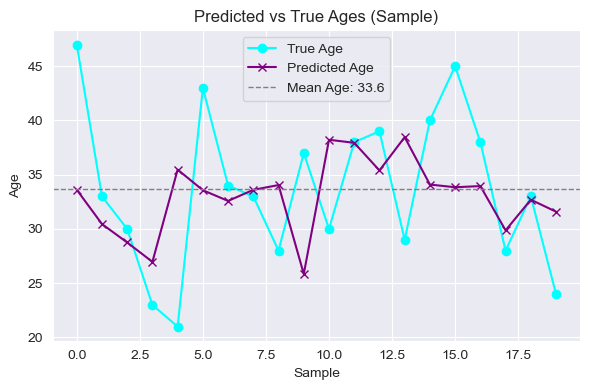

In [271]:
plot_model_performance(model, sample_count=20)

### Simple Model with Advanced Data Preprocessing

In [239]:
class AgePredictorV2(AgePredictor):
    def predict(self, X):
        with torch.no_grad():
            X = torch.FloatTensor(X).to(device)
            return self(X).cpu().numpy().reshape(-1, 1)

#### Training

In [244]:
# Initialize model, loss and optimizer
simple_model_adv_data = AgePredictorV2(X_train.shape[1]).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Training loop

train_loader_final, test_loader_final = get_loaders_from_df(X_train_final, y_train_final, X_test_final, y_test_final)

num_epochs = 10
# Compute total steps
total_steps = num_epochs * (len(train_loader) + len(test_loader))
progress_bar = tqdm(total=total_steps, desc="Training Progress", leave=False)
for epoch in range(num_epochs):
    model.train()
    train_loss_total = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

        train_loss_total += loss.item()
        progress_bar.update(1)
        progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs} [Train]")
        progress_bar.set_postfix(loss=loss.item())

    model.eval()
    val_loss_total = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets).item()
            val_loss_total += loss
            progress_bar.update(1)
            progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs} [Val]")
            progress_bar.set_postfix(loss=loss)

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{num_epochs} - "
          f"Train Loss: {train_loss_total / len(train_loader):.4f} | "
          f"Val Loss: {val_loss_total / len(test_loader):.4f}")

progress_bar.close()

Training Progress:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 5.3011 | Val Loss: 5.5688
Epoch 2/10 - Train Loss: 5.2657 | Val Loss: 5.5720
Epoch 3/10 - Train Loss: 5.2664 | Val Loss: 5.5529
Epoch 4/10 - Train Loss: 5.2561 | Val Loss: 5.5526
Epoch 5/10 - Train Loss: 5.2313 | Val Loss: 5.5573
Epoch 6/10 - Train Loss: 5.2215 | Val Loss: 5.6321
Epoch 7/10 - Train Loss: 5.2255 | Val Loss: 5.5882
Epoch 8/10 - Train Loss: 5.2235 | Val Loss: 5.5742
Epoch 9/10 - Train Loss: 5.2046 | Val Loss: 5.5380
Epoch 10/10 - Train Loss: 5.2023 | Val Loss: 5.6302


#### Plotting

In [251]:
# plot_model_performance(simple_model_adv_data)
# simple_model_adv_data.predict(train_loader_final.sample())
plot_model_performance(model, X_train_final, X_test_final, y_train_final, y_test_final)

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (53092x54 and 66x256)

### Advanced Claude Assisted Model

In [146]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


class ImprovedAgePredictor(nn.Module):
    def __init__(self, input_size, dropout_rate=0.3):
        super(ImprovedAgePredictor, self).__init__()

        # Batch normalization for better training stability
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.5),  # Reduced dropout in final layers

            nn.Linear(64, 1)
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x):
        return self.layers(x)

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            if isinstance(X, pd.DataFrame):
                X = torch.FloatTensor(X.values)
            elif isinstance(X, np.ndarray):
                X = torch.FloatTensor(X)

            X = X.to(next(self.parameters()).device)
            predictions = self(X).cpu().numpy().flatten()

            # Apply reasonable age bounds
            predictions = np.clip(predictions, 13, 100)
            return predictions

#### Training

In [203]:
def train_improved_model(train_loader, test_loader, epochs=100, patience=25):
    # No scaling of target - keep age in original scale 
    model = ImprovedAgePredictor(next(iter(train_loader))[0].shape[1])

    criterion = nn.L1Loss()
    optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    best_val_loss = float('inf')
    patience_counter = 0

    # Calculate total steps for progress bar
    total_steps = epochs * (len(train_loader) + len(test_loader))
    progress_bar = tqdm(total=total_steps, desc='Training Progress')

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_loss += loss.item()

            # Update progress bar
            progress_bar.update(1)
            progress_bar.set_postfix(loss=loss.item(), phase='train')

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                outputs = model(batch_x).squeeze()
                val_loss += criterion(outputs, batch_y).item()
                # Update progress bar
                progress_bar.update(1)
                progress_bar.set_postfix(loss=val_loss / len(test_loader), phase='val')

        train_loss /= len(train_loader)
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_age_model.pth')
        else:
            patience_counter += 1

        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    progress_bar.close()
    # Load best model
    model.load_state_dict(torch.load('best_age_model.pth'))
    return model


In [204]:
new_model = train_improved_model(*get_loaders(scaled=False))

/Users/david/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training Progress:   0%|          | 0/40700 [00:00<?, ?it/s]

Epoch 0: Train Loss: 8.0738, Val Loss: 5.9875
Epoch 10: Train Loss: 5.8533, Val Loss: 5.5506
Epoch 20: Train Loss: 5.5911, Val Loss: 5.5138
Epoch 30: Train Loss: 5.3795, Val Loss: 5.6081
Early stopping at epoch 38


#### Plotting a sample test

Sample 1 — True Age: 47.0, Predicted Age: 35.0
Sample 11 — True Age: 30.0, Predicted Age: 38.3
Train MAE: 5.36
Test MAE: 5.51


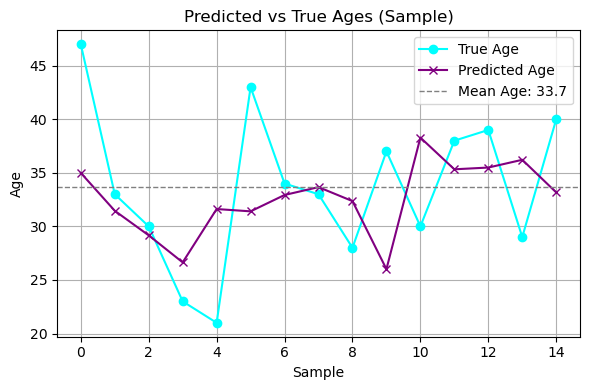

In [205]:
plot_model_performance(new_model)

### Testing mean and median errors

MAE using mean (32.65) as predictor: 6.10
MAE using median (32.00) as predictor: 6.04


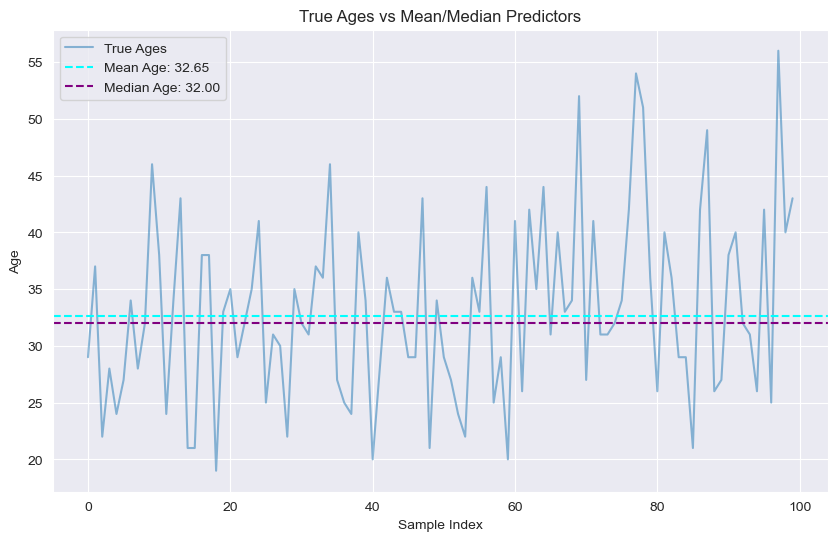

In [268]:
actual_ages = y_test.values
mean_predictor = np.full_like(actual_ages, actual_ages.mean())
median_predictor = np.full_like(actual_ages, np.median(actual_ages))

mean_mae = mae(actual_ages, mean_predictor)
median_mae = mae(actual_ages, median_predictor)

print(f"MAE using mean ({actual_ages.mean():.2f}) as predictor: {mean_mae:.2f}")
print(f"MAE using median ({np.median(actual_ages):.2f}) as predictor: {median_mae:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(actual_ages[:100], label='True Ages', alpha=0.5)
plt.axhline(y=actual_ages.mean(), color='cyaN', linestyle='--', label=f'Mean Age: {actual_ages.mean():.2f}')
plt.axhline(y=np.median(actual_ages), color='purple', linestyle='--', label=f'Median Age: {np.median(actual_ages):.2f}')
plt.title('True Ages vs Mean/Median Predictors')
plt.xlabel('Sample Index')
plt.ylabel('Age')
plt.legend()
plt.grid(True)
plt.show()


In [190]:
# Check your target distribution
print("Age statistics:")
print(f"Min age: {y_train.min()}")
print(f"Max age: {y_train.max()}")
print(f"Mean age: {y_train.mean():.2f}")
print(f"Std age: {y_train.std():.2f}")

# Verify you're not using log-scaled targets
print(f"Sample ages: {y_train.head().tolist()}")

Age statistics:
Min age: 18.0
Max age: 100.0
Mean age: 32.75
Std age: 8.02
Sample ages: [30.0, 33.0, 36.0, 44.0, 47.0]


In [194]:
import torch
import torch.nn as nn
import torch.optim as optim


class SimpleAgePredictor(nn.Module):
    def __init__(self, input_size):
        super(SimpleAgePredictor, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),  # Much lower dropout

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(64, 1)
        )

        # Better weight initialization for age prediction
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # He initialization for ReLU
            torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            # Initialize bias to reasonable age value
            if m.bias is not None:
                m.bias.data.fill_(0.1)

    def forward(self, x):
        return self.layers(x)

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            if isinstance(X, pd.DataFrame):
                X = torch.FloatTensor(X.values)
            elif isinstance(X, np.ndarray):
                X = torch.FloatTensor(X)

            X = X.to(next(self.parameters()).device)
            predictions = self(X).cpu().numpy().flatten()

            # Apply reasonable age bounds
            predictions = np.clip(predictions, 13, 100)
            return predictions


def train_simple_model(train_loader, test_loader, epochs=50, patience=10):
    # Get input size from first batch
    input_size = next(iter(train_loader))[0].shape[1]
    model = SimpleAgePredictor(input_size)

    # L1 loss as requested
    criterion = nn.L1Loss()

    # Much lower learning rate and no weight decay initially
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    # Simple learning rate reduction
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()

            # Light gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                outputs = model(batch_x).squeeze()
                val_loss += criterion(outputs, batch_y).item()

        train_loss /= len(train_loader)
        val_loss /= len(test_loader)

        scheduler.step()

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_simple_model.pth')
        else:
            patience_counter += 1

        if epoch % 5 == 0:
            print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

            # Debug: Check actual predictions
            with torch.no_grad():
                sample_batch = next(iter(test_loader))
                sample_preds = model(sample_batch[0]).squeeze()
                print(f'  Sample predictions: {sample_preds[:5].tolist()}')
                print(f'  Sample targets: {sample_batch[1][:5].tolist()}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    # Load best model
    model.load_state_dict(torch.load('best_simple_model.pth'))
    return model


train_loader, test_loader = get_loaders(scaled=False)
# Train the simplified model
simple_model = train_simple_model(train_loader, test_loader)


Epoch 0: Train Loss: 7.6774, Val Loss: 5.5637
  Sample predictions: [28.000629425048828, 34.768524169921875, 27.08013916015625, 36.349098205566406, 30.423583984375]
  Sample targets: [29.0, 37.0, 22.0, 28.0, 24.0]
Epoch 5: Train Loss: 5.9127, Val Loss: 5.4931
  Sample predictions: [28.03162956237793, 34.760860443115234, 27.740915298461914, 36.684776306152344, 31.4598445892334]
  Sample targets: [29.0, 37.0, 22.0, 28.0, 24.0]
Epoch 10: Train Loss: 5.8739, Val Loss: 5.4895
  Sample predictions: [27.03580665588379, 35.17111587524414, 26.570262908935547, 35.59431076049805, 30.716571807861328]
  Sample targets: [29.0, 37.0, 22.0, 28.0, 24.0]
Epoch 15: Train Loss: 5.7901, Val Loss: 5.4862
  Sample predictions: [26.489492416381836, 34.46131896972656, 26.4193172454834, 35.06920623779297, 31.12163734436035]
  Sample targets: [29.0, 37.0, 22.0, 28.0, 24.0]
Early stopping at epoch 18


Sample 1 — True Age: 47.0, Predicted Age: 34.5
Sample 11 — True Age: 30.0, Predicted Age: 38.8
Train MAE: 5.44
Test MAE: 5.48


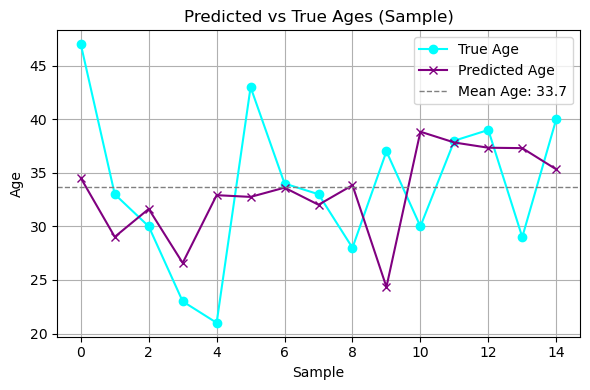

In [195]:
plot_model_performance(simple_model)

In [196]:
# First, check raw model outputs WITHOUT clipping
def debug_model_predictions(model, test_loader):
    model.eval()
    with torch.no_grad():
        batch_x, batch_y = next(iter(test_loader))
        raw_outputs = model(batch_x).squeeze()

        print("Raw model outputs (before clipping):")
        print(f"  Min: {raw_outputs.min().item():.4f}")
        print(f"  Max: {raw_outputs.max().item():.4f}")
        print(f"  Mean: {raw_outputs.mean().item():.4f}")
        print(f"  Sample values: {raw_outputs[:10].tolist()}")

        print("\nActual target values:")
        print(f"  Min: {batch_y.min().item():.4f}")
        print(f"  Max: {batch_y.max().item():.4f}")
        print(f"  Mean: {batch_y.mean().item():.4f}")
        print(f"  Sample values: {batch_y[:10].tolist()}")


# Run this after training
debug_model_predictions(simple_model, test_loader)


Raw model outputs (before clipping):
  Min: 20.8591
  Max: 39.8774
  Mean: 30.9018
  Sample values: [25.897607803344727, 35.061344146728516, 26.817171096801758, 36.046112060546875, 31.22743034362793, 31.275554656982422, 33.69536209106445, 27.44202423095703, 32.120445251464844, 31.003128051757812]

Actual target values:
  Min: 19.0000
  Max: 46.0000
  Mean: 31.2812
  Sample values: [29.0, 37.0, 22.0, 28.0, 24.0, 27.0, 34.0, 28.0, 32.0, 46.0]


In [207]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd


# Analyze feature importance
def analyze_question_predictiveness(X, y):
    """Find which survey questions best predict age"""

    # Calculate mutual information for each feature
    mi_scores = mutual_info_regression(X, y, random_state=42)

    # Create feature importance dataframe
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'mi_score': mi_scores
    }).sort_values('mi_score', ascending=False)

    print("Top 10 most age-predictive questions:")
    print(feature_importance.head(20))

    # Focus on top features
    top_features = feature_importance.head(50)['feature'].tolist()
    return X[top_features]


# Use only most predictive features
X_filtered = analyze_question_predictiveness(X_train, y_train)

Top 10 most age-predictive questions:
                                            feature  mi_score
43  q16053_Hesitant, but I'd certainly consider it.  0.032220
45                          q16053_Totally willing!  0.027452
20                            q154_No, it wouldn't.  0.018819
9                                         q48_Weird  0.017244
21                              q154_Yes, it would.  0.014299
10                                        q77_Never  0.014043
46                                   q20930_Average  0.011712
35                                        q1597_Yes  0.011170
6                                          q46_Good  0.010679
17  q80_I've done drugs in the past, but no longer.  0.010633
14                     q80_I do drugs occasionally.  0.010390
5                            q41_Somewhat important  0.010304
62                                         q1440_No  0.009193
23                                         q325_Yes  0.009133
55                              